Load in df data from prev notebook.
* `munge_pt2_disease_hierarchy.ipynb`
*  `df_temp = pd.concat([X,y])
df_temp.to_parquet("features_data_export.parquet")`

Run comparative  evaluation between ml models + output figure

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import f_classif, chi2,SelectFromModel,SelectKBest,mutual_info_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV, RidgeCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score,GroupKFold,cross_validate,StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report,average_precision_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFpr, SelectFdr
import re
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.compose import ColumnTransformer

from catboost import Pool, CatBoostClassifier
from scipy.stats import mode
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, RepeatedStratifiedKFold
from scipy.stats import ttest_rel, chi2, ttest_ind
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import seaborn as sns

from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import make_scorer
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

from sklearn import set_config
set_config(transform_output = "pandas")

In [3]:
DO_DL= True
SAVE_CANDIDATES = False#True # save output predicted candidates - overwrites
DO_LEAKY_FS = False#True# # leaky train on train feature sel..  - only used during debugging

FASTRUN =  False
# FASTRUN =  True#False

In [4]:
from re import sub

def prettify_feature_names(s):
    """replace _ with space and camel case and additional changes to make output feature names look nicer"""
    
    s = s.replace("_000000"," ").replace("pct","Percent").replace("dl_","Text Embedding Vector ").replace("ENSG00000","ENSG ")
    s = s.replace("Evidencecount","Evidence count").replace("byDisease","by Disease")
    s = sub(r"(_|-)+", " ", s).title()
    return ''.join(s)

#### Export data

In [5]:
if DO_DL:
    df = pd.read_parquet("features_data_DL_export.parquet")
else: 
    df = pd.read_parquet("features_data_export.parquet") # no deep learning/text features
    
df = df.convert_dtypes(convert_string=False) ## parses ~ 990 floats ot int. Note that memory usage isn't actualy lowered/;
df["has_children"] = df["has_children"].astype(int)

if FASTRUN:
    df = df.sample(frac=0.05)
df

,animal_model,All_ICD_counts,num_parents,pct_somatic_mutation,affected_pathway_ratio_to_biggest,num_therapeuticAreas,pct_animal_model,animal_model_ratio_to_smallest,rna_expression_ratio_to_smallest,literature_ratio_to_biggest,...,dl_759,dl_760,dl_761,dl_762,dl_763,dl_764,dl_765,dl_766,dl_767,has_children
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,2,0,1,0.0,0.0,16,50.0,1.0,0.0,0.0,...,-0.008973,-0.011922,-0.029698,0.030446,0.015639,-0.01488,-0.054027,-0.022872,0.01314,0
10q22.3q23.3 microduplication syndrome,4,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,0.009407,0.028488,-0.023618,0.013682,-0.000997,-0.021142,-0.05629,-0.03345,-0.007414,0
11p15.4 microduplication syndrome,0,0,3,0.0,0.0,16,0.0,0.0,0.0,0.0,...,0.016148,-0.016285,-0.033168,0.020486,0.01425,-0.003042,-0.081733,0.039752,0.008476,0
12p12.1 microdeletion syndrome,2,0,0,0.0,0.0,16,66.6667,2.0,0.0,0.0,...,-0.021291,-0.043856,-0.018003,0.003387,0.038978,-0.032084,-0.048926,-0.005518,-0.003645,0
12q14 microdeletion syndrome,169,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,-0.006823,-0.014591,-0.029553,0.015847,0.070078,0.016362,-0.062399,0.046976,-0.007567,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,0.005693,0.02738,-0.031438,-0.023347,0.008283,0.025569,-0.041679,0.053067,-0.018215,0
zygodactyly type 2,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,-0.001348,0.010197,-0.03201,-0.018714,-0.008233,0.016151,-0.036483,0.029733,-0.026667,0
zygodactyly type 3,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,-0.007073,0.012932,-0.019908,-0.003233,0.015318,0.002056,-0.046798,0.044081,-0.021982,0


In [6]:
%%time
if DO_LEAKY_FS or FASTRUN:
    K_Feats = 8 if FASTRUN else 3100
    ## leaky FS 
    # fs = SelectFpr(score_func=chi2,alpha=0.25)
    fs = Pipeline([ ("var",VarianceThreshold(0.0005)),
        ("SimpleImputer",SimpleImputer(strategy="most_frequent")),
#         ("statf",SelectFpr(score_func= f_classif,alpha=0.01)),
#           ("statk",SelectKBest(score_func= f_classif,k=K_Feats))
                  ])
    X = df.drop(columns="has_children").select_dtypes("number")
    X.columns = X.columns.astype(str)
    X.fillna(0,inplace=True)
    y = df["has_children"]
    fs.fit(X,y)
    ##LEAKY!!!: 
    print("pre filt",df.shape) # 4182
    df = df.filter(["source","has_children","Phenotype_counts"]+list(fs.get_feature_names_out()),axis=1)
    df = df.loc[:,~df.columns.duplicated()].copy() # drop a col getting duplicated  Phenotype_counts
    X = X.filter(["source","Phenotype_counts"]+list(fs.get_feature_names_out()),axis=1)
    print(df.shape)  # 40281

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.58 µs


In [7]:
df

,animal_model,All_ICD_counts,num_parents,pct_somatic_mutation,affected_pathway_ratio_to_biggest,num_therapeuticAreas,pct_animal_model,animal_model_ratio_to_smallest,rna_expression_ratio_to_smallest,literature_ratio_to_biggest,...,dl_759,dl_760,dl_761,dl_762,dl_763,dl_764,dl_765,dl_766,dl_767,has_children
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,2,0,1,0.0,0.0,16,50.0,1.0,0.0,0.0,...,-0.008973,-0.011922,-0.029698,0.030446,0.015639,-0.01488,-0.054027,-0.022872,0.01314,0
10q22.3q23.3 microduplication syndrome,4,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,0.009407,0.028488,-0.023618,0.013682,-0.000997,-0.021142,-0.05629,-0.03345,-0.007414,0
11p15.4 microduplication syndrome,0,0,3,0.0,0.0,16,0.0,0.0,0.0,0.0,...,0.016148,-0.016285,-0.033168,0.020486,0.01425,-0.003042,-0.081733,0.039752,0.008476,0
12p12.1 microdeletion syndrome,2,0,0,0.0,0.0,16,66.6667,2.0,0.0,0.0,...,-0.021291,-0.043856,-0.018003,0.003387,0.038978,-0.032084,-0.048926,-0.005518,-0.003645,0
12q14 microdeletion syndrome,169,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,-0.006823,-0.014591,-0.029553,0.015847,0.070078,0.016362,-0.062399,0.046976,-0.007567,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,0.005693,0.02738,-0.031438,-0.023347,0.008283,0.025569,-0.041679,0.053067,-0.018215,0
zygodactyly type 2,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,-0.001348,0.010197,-0.03201,-0.018714,-0.008233,0.016151,-0.036483,0.029733,-0.026667,0
zygodactyly type 3,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,-0.007073,0.012932,-0.019908,-0.003233,0.015318,0.002056,-0.046798,0.044081,-0.021982,0


In [8]:
X = df.drop(columns=["has_children"],errors="ignore")
print(X.shape)
y = df["has_children"]
assert y.dropna().sum()>50
print(y.agg(["count","mean","sum"]).round(2))

assert y.shape[0]==X.shape[0]

(17222, 3200)
count    17222.00
mean         0.34
sum       5848.00
Name: has_children, dtype: float64


In [9]:
# ## OPT: String / categorical feature of disease source. may be leak or bias??
# X["source"] = [i[0] for i in list(X.index.str.split("_",expand=True))]## ORIG before index change with grp#[:,0]
## warning - ordinal instead of OHE encoding
 # useful for running other models
lbl = LabelEncoder().fit(X.source)
cat_col = X.columns.get_loc("source")
X.iloc[:,cat_col]
X.iloc[:,cat_col] = lbl.transform(X.source)
X

,animal_model,All_ICD_counts,num_parents,pct_somatic_mutation,affected_pathway_ratio_to_biggest,num_therapeuticAreas,pct_animal_model,animal_model_ratio_to_smallest,rna_expression_ratio_to_smallest,literature_ratio_to_biggest,...,dl_758,dl_759,dl_760,dl_761,dl_762,dl_763,dl_764,dl_765,dl_766,dl_767
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,2,0,1,0.0,0.0,16,50.0,1.0,0.0,0.0,...,0.038011,-0.008973,-0.011922,-0.029698,0.030446,0.015639,-0.01488,-0.054027,-0.022872,0.01314
10q22.3q23.3 microduplication syndrome,4,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,0.031007,0.009407,0.028488,-0.023618,0.013682,-0.000997,-0.021142,-0.05629,-0.03345,-0.007414
11p15.4 microduplication syndrome,0,0,3,0.0,0.0,16,0.0,0.0,0.0,0.0,...,0.01897,0.016148,-0.016285,-0.033168,0.020486,0.01425,-0.003042,-0.081733,0.039752,0.008476
12p12.1 microdeletion syndrome,2,0,0,0.0,0.0,16,66.6667,2.0,0.0,0.0,...,0.020466,-0.021291,-0.043856,-0.018003,0.003387,0.038978,-0.032084,-0.048926,-0.005518,-0.003645
12q14 microdeletion syndrome,169,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,0.01915,-0.006823,-0.014591,-0.029553,0.015847,0.070078,0.016362,-0.062399,0.046976,-0.007567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,0.014381,0.005693,0.02738,-0.031438,-0.023347,0.008283,0.025569,-0.041679,0.053067,-0.018215
zygodactyly type 2,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,0.014625,-0.001348,0.010197,-0.03201,-0.018714,-0.008233,0.016151,-0.036483,0.029733,-0.026667
zygodactyly type 3,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,0.016962,-0.007073,0.012932,-0.019908,-0.003233,0.015318,0.002056,-0.046798,0.044081,-0.021982


* alt: could use repeatedKFold (note that then we wouldn't get per sample multiple predictions trivially);
```
# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=7, random_state=1)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
```

In [10]:
num_columns = X.select_dtypes(include=['number']).columns.tolist()
cat_columns = X.select_dtypes(include=["O",'object',"string"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent',add_indicator=True)),
    ('label', OneHotEncoder(handle_unknown='ignore',min_frequency=2,sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, cat_columns)])


* Note: SqtBalanced was out default picked model, as a good prior to imbalanced data. 
    I include results with the default catboost (no weighting) As a contrast, but this was not used when ceating and picking the model initially.  

In [11]:
clf_lr = Pipeline(steps=[('preprocessor', preprocessor),('LogisticRegression',LogisticRegression())])
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),('RF',RandomForestClassifier(n_jobs=-2))])

clf_cb = CatBoostClassifier(cat_features=["source"],verbose=False, task_type="GPU")   
clf_cb2 = CatBoostClassifier(cat_features=["source"],verbose=False,auto_class_weights = "SqrtBalanced", task_type="GPU")  
clf_histgb = Pipeline(steps=[('preprocessor', preprocessor),('histgb',HistGradientBoostingClassifier())])
clf_cb_proc = Pipeline(steps=[('preprocessor', preprocessor),('cb',CatBoostClassifier(auto_class_weights = "SqrtBalanced",
                                                                                      verbose=False, task_type="GPU"))])
clf_knn =  Pipeline(steps=[('preprocessor', preprocessor),('KNN',KNeighborsClassifier(n_jobs=-2,weights="distance"))])
clf_svc =  Pipeline(steps=[('preprocessor', preprocessor),('LinearSVM',SGDClassifier(loss="modified_huber"))]) # huber loss needed for svm + proba, at scale

In [12]:
cv = StratifiedKFold(n_splits=2 if FASTRUN else 5, random_state=42, shuffle=True)


In [12]:
%%time
# # list of models to evaluate: 
classifiers = {
    'Logistic Regression': clf_lr,
    'Random Forest': clf_rf,
    "sklearn-HistGradientBoosting":clf_histgb,
    "SVM-SVC":clf_svc,
    "CatBoost":clf_cb_proc,
    "KNN": clf_knn,
    'CatBoost-NoImpute-ClassWeighted': clf_cb2,
    'CatBoost-NoImpute': clf_cb ## SqrtBalanced
}

# Initialize the data frame to store the results
results_df = pd.DataFrame()
# Define the scoring metrics
scoring = {'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
            'pr_auc': make_scorer(average_precision_score, needs_proba=True),
          'prec': 'precision',"recall":"recall","acc":"accuracy",
          "MCC":"matthews_corrcoef"}

for clf_name, clf in classifiers.items():
    print(clf_name)
    # Perform cross-validation
    scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, return_train_score=False)
    # Store the results into the data frame
    results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
    results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
    results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
    results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
    
    results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
    results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
    results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
    results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
    results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
    results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()
    results_df.loc[clf_name, 'MCC Mean'] = scores['test_MCC'].mean()
    results_df.loc[clf_name, 'MCC SD'] = scores['test_MCC'].std()

###############################    
### baseline models
clf_name = "Source Baseline"
scores = cross_validate(LogisticRegression(), OneHotEncoder(handle_unknown='ignore',min_frequency=2,sparse_output=False).fit_transform(X[["source"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()
results_df.loc[clf_name, 'MCC Mean'] = scores['test_MCC'].mean()
results_df.loc[clf_name, 'MCC SD'] = scores['test_MCC'].std()

clf_name = "Phenotype Baseline"
scores = cross_validate(LogisticRegression(), numeric_transformer.fit_transform(X[["Phenotype_counts"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()
results_df.loc[clf_name, 'MCC Mean'] = scores['test_MCC'].mean()
results_df.loc[clf_name, 'MCC SD'] = scores['test_MCC'].std()
try:
    clf_name = "Max Phenotype frequency Baseline"
    scores = cross_validate(LogisticRegression(), numeric_transformer.fit_transform(X[["max_phenotype_frequency"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
    results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
    results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
    results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
    results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
    results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
    results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
    results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
    results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
    results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
    results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()
    results_df.loc[clf_name, 'MCC Mean'] = scores['test_MCC'].mean()
    results_df.loc[clf_name, 'MCC SD'] = scores['test_MCC'].std()
except: 
    print("max pheno feature missing")
    
clf_name = "#Siblings Baseline"
scores = cross_validate(LogisticRegression(), numeric_transformer.fit_transform(X[["num_siblings"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()
results_df.loc[clf_name, 'MCC Mean'] = scores['test_MCC'].mean()
results_df.loc[clf_name, 'MCC SD'] = scores['test_MCC'].std()

###
if not FASTRUN:
    print("No Text - Catboost Without Text Features")
    clf_name = "No Text"
    X2 = X.drop(columns=list(X.columns[X.columns.str.contains("dl_")]),errors="ignore")
    scores = cross_validate(clf_cb, X2, y, cv=cv, scoring=scoring, return_train_score=False)

    results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
    results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
    results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
    results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
    results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
    results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
    results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
    results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
    results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
    results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()
    results_df.loc[clf_name, 'MCC Mean'] = scores['test_MCC'].mean()
    results_df.loc[clf_name, 'MCC SD'] = scores['test_MCC'].std()
#########
results_df.dropna(how="all",axis=1,inplace=True)
results_df = results_df.round(4)*100
results_df.sort_values("ROCAUC Mean",inplace=True)
# Print the result
print(results_df)

if SAVE_CANDIDATES:
    if not FASTRUN: 
        results_df.dropna(how="all",axis=0).to_csv("./outputs/Table-1-Known disease subtype models evaluation.csv") # Table-1-Known disease submanifestation prediction.csv
        results_df.dropna(how="all",axis=0).to_csv("./outputs/S3-Table-Known disease subtype models evaluation.csv") # copy

Logistic Regression


/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Random Forest
sklearn-HistGradientBoosting
SVM-SVC
CatBoost
KNN
CatBoost-NoImpute-ClassWeighted
CatBoost-NoImpute
Doing Baselines


/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469

No Text - Catboost Without Text Features
                                  ROCAUC Mean  ROCAUC SD  PRAUC Mean  \
#Siblings Baseline                      52.35       0.52       35.28   
Source Baseline                         55.86       0.55       37.67   
Phenotype Baseline                      66.42       0.42       44.60   
Max Phenotype frequency Baseline        66.44       0.50       44.31   
KNN                                     73.58       0.67       59.79   
SVM-SVC                                 73.90       1.24       54.30   
Logistic Regression                     80.83       0.70       64.81   
No Text                                 85.80       0.51       76.28   
Random Forest                           86.45       0.68       79.19   
CatBoost-NoImpute                       89.01       0.54       83.53   
CatBoost-NoImpute-ClassWeighted         89.14       0.52       83.60   
sklearn-HistGradientBoosting            89.46       0.55       84.21   
CatBoost               

In [15]:
results_df.dropna(how="all",axis=0).to_csv("./outputs/S3-Table-Known disease subtype models evaluation.csv")

In [13]:
display(results_df)

,ROCAUC Mean,ROCAUC SD,PRAUC Mean,PRAUC SD,Precision Mean,Precision SD,Recall Mean,Recall SD,Acc Mean,Acc SD,MCC Mean,MCC SD
#Siblings Baseline,52.35,0.52,35.28,0.32,0.00,0.00,0.00,0.00,66.04,0.01,0.00,0.00
Source Baseline,55.86,0.55,37.67,0.26,57.67,2.15,3.63,0.42,66.36,0.08,7.36,0.51
Phenotype Baseline,66.42,0.42,44.60,0.34,0.00,0.00,0.00,0.00,66.04,0.01,0.00,0.00
Max Phenotype frequency Baseline,66.44,0.50,44.31,0.38,0.00,0.00,0.00,0.00,66.04,0.01,0.00,0.00
KNN,73.58,0.67,59.79,0.86,49.91,0.84,69.58,1.25,65.95,0.79,31.94,1.33
SVM-SVC,73.90,1.24,54.30,1.53,63.70,1.85,66.47,2.65,75.72,1.08,46.50,2.24
Logistic Regression,80.83,0.70,64.81,1.36,66.70,0.76,69.27,1.09,77.82,0.48,51.03,1.07
No Text,85.80,0.51,76.28,0.35,74.16,0.82,62.57,1.81,79.87,0.18,53.78,0.56
Random Forest,86.45,0.68,79.19,1.19,83.46,1.00,53.35,2.15,80.57,0.72,55.04,1.78
CatBoost-NoImpute,89.01,0.54,83.53,0.85,81.06,0.86,67.44,1.41,83.59,0.50,62.41,1.19


## FIG 3
### output rocauc, prauc for selection of models
* done seperately since we need to rerun anyway , and this way we can easily control which models to use

/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

baseline


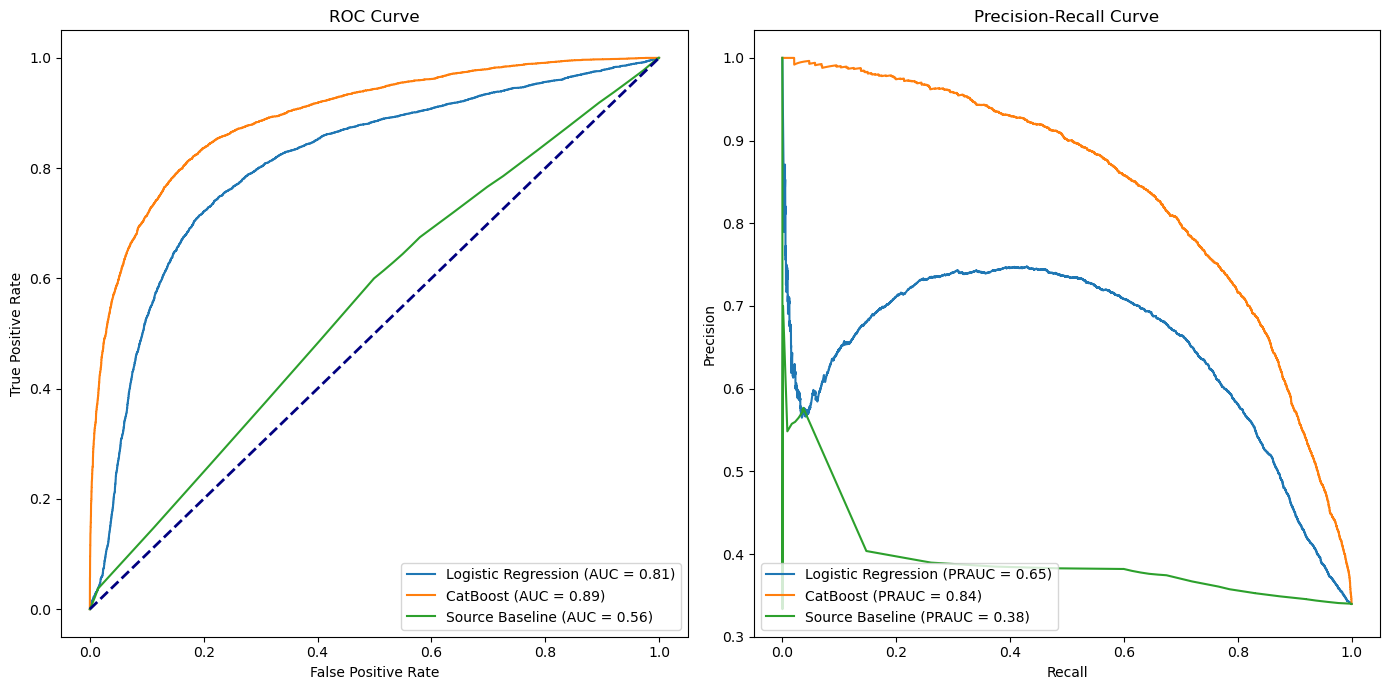

CPU times: user 7min 14s, sys: 1min 3s, total: 8min 17s
Wall time: 5min 7s


In [14]:
%%time
# Assuming clf_lr, clf_rf, clf_cb are predefined classifiers
classifiers = {
    'Logistic Regression': clf_lr,
    'CatBoost': clf_cb_proc#clf_cb # SqrtBalanced
}

# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 14))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 7))

for clf_name, clf in classifiers.items():
    # Predict probabilities for ROC and PR curves
    y_pred = cross_val_predict(estimator=clf, X=X, y=y, cv=cv, method="predict_proba")[:,1]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc = (round(roc_auc_score(y, y_pred) , 2))
    ax1.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc})')
    
    # PR Curve
    precision, recall, _ = precision_recall_curve(y, y_pred)
    ap = (round(average_precision_score(y, y_pred), 2))
    ax2.plot(recall, precision, label=f'{clf_name} (PRAUC = {ap})')
print("baseline")
# Baseline Model
clf_name = "Source Baseline"
y_pred = cross_val_predict(estimator=LogisticRegression(), X=OneHotEncoder(handle_unknown='ignore',
                                                                           min_frequency=2,sparse_output=False).fit_transform(X[["source"]]),
                           y=y, cv=cv, n_jobs=2, method="predict_proba")[:,1]

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_pred)
auc = (round(roc_auc_score(y, y_pred), 2))
ax1.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc})')

# PR Curve
precision, recall, _ = precision_recall_curve(y, y_pred)
ap = (round(average_precision_score(y, y_pred), 2))
ax2.plot(recall, precision, label=f'{clf_name} (PRAUC = {ap})')

# Plot 50 AUC baseline for ROC curve
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Configure plots
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

ax2.set_title('Precision-Recall Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='lower left')
plt.tight_layout()

##TODO: not actually saved to output>
if SAVE_CANDIDATES:
    if not FASTRUN:
        plt.savefig('./outputs/Fig-3-roc_pr_curves.png', dpi=940)
        
plt.show()

## Model without novel predictions
* Retrain model with predicted novel subtypes ; then see it's preds

In [13]:
df_novel_preds = pd.read_csv("./outputs/S1-candidate_errors.csv")
df_novel_preds

,name,value_HP_0001795,value_HP_0000453,score_ENSG00000132781,value_HP_0000883,score_ENSG00000113448,dl_479,value_HP_0000695,dl_29,value_HP_0003233,...,dl_413,score_ENSG00000166147,value_HP_0001566,dl_453,value_HP_0009473,dl_285,value_HP_0001281,value_HP_0003577,CV_pred,CV_mean
0,abnormality of glycosaminoglycan metabolism,0,0,0.0,0,0.0,-0.04,0,0.02,0,...,-0.06,0.00,0,0.08,0,0.04,0,0,1,0.98
1,structural epilepsy,0,0,0.0,0,0.0,-0.03,0,0.03,0,...,-0.01,0.00,0,-0.02,0,0.02,0,0,1,0.98
2,nephropathy,0,0,0.0,0,0.0,0.03,0,-0.01,0,...,-0.02,0.00,0,0.05,0,-0.09,0,0,1,0.98
3,extrapyramidal and movement disease,0,0,0.0,0,0.0,0.04,0,0.04,0,...,0.04,0.00,0,-0.13,0,-0.04,0,0,1,0.98
4,sexual and gender identity disorders,0,0,0.0,0,0.0,0.01,0,0.08,0,...,-0.08,0.00,0,-0.07,0,-0.00,0,0,1,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,atrial septal defect 1,0,0,0.0,0,0.0,-0.01,0,0.01,0,...,0.02,0.05,0,-0.03,0,0.00,0,0,0,0.02
1527,acheiropodia,0,0,0.0,0,0.0,-0.01,0,0.02,0,...,-0.01,0.06,0,0.01,0,-0.02,0,0,0,0.01
1528,becker nevus syndrome,0,0,0.0,0,0.0,-0.00,0,0.06,0,...,-0.03,0.00,0,-0.00,0,0.02,0,0,0,0.01
1529,x-linked intellectual disability - hypogammagl...,0,0,0.0,0,0.0,-0.05,0,-0.01,0,...,-0.03,0.00,0,0.04,0,-0.03,0,0,0,0.01


In [15]:
df_novel_preds.loc[df_novel_preds["has_children"]==0]

,name,value_HP_0001795,value_HP_0000453,score_ENSG00000132781,value_HP_0000883,score_ENSG00000113448,dl_479,value_HP_0000695,dl_29,value_HP_0003233,...,dl_413,score_ENSG00000166147,value_HP_0001566,dl_453,value_HP_0009473,dl_285,value_HP_0001281,value_HP_0003577,CV_pred,CV_mean
0,abnormality of glycosaminoglycan metabolism,0,0,0.0,0,0.0,-0.04,0,0.02,0,...,-0.06,0.0,0,0.08,0,0.04,0,0,1,0.98
1,structural epilepsy,0,0,0.0,0,0.0,-0.03,0,0.03,0,...,-0.01,0.0,0,-0.02,0,0.02,0,0,1,0.98
2,nephropathy,0,0,0.0,0,0.0,0.03,0,-0.01,0,...,-0.02,0.0,0,0.05,0,-0.09,0,0,1,0.98
3,extrapyramidal and movement disease,0,0,0.0,0,0.0,0.04,0,0.04,0,...,0.04,0.0,0,-0.13,0,-0.04,0,0,1,0.98
4,sexual and gender identity disorders,0,0,0.0,0,0.0,0.01,0,0.08,0,...,-0.08,0.0,0,-0.07,0,-0.00,0,0,1,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,cryptosporidiosis,0,0,0.0,0,0.0,-0.01,0,0.02,0,...,-0.02,0.0,0,-0.01,0,0.03,0,0,1,0.58
499,urachal cyst,0,0,0.0,0,0.0,-0.05,0,-0.06,0,...,0.01,0.0,0,0.02,0,-0.01,0,0,1,0.58
500,phosphohydroxylysinuria,0,0,0.0,0,0.0,-0.01,0,0.02,0,...,0.00,0.0,0,0.01,0,0.01,0,0,1,0.58
501,urinary tract smooth muscle contraction,0,0,0.0,0,0.0,0.04,0,0.01,0,...,0.05,0.0,0,0.06,0,-0.04,0,0,1,0.57


In [25]:
df2 = df.reset_index().copy()
## drop ~503 rows with novel pred 1
df_novelty2 = df2.loc[df2["name"].isin(df_novel_preds.loc[df_novel_preds["has_children"]==0]["name"])]
print(df_novelty2.shape[0],"df_novelty2")
df2 = df2.loc[~df2["name"].isin(df_novel_preds.loc[df_novel_preds["has_children"]==0]["name"])]
df2.set_index("name",inplace=True)
df_novelty2.set_index("name",inplace=True)
df2

503 df_novelty2


,animal_model,All_ICD_counts,num_parents,pct_somatic_mutation,affected_pathway_ratio_to_biggest,num_therapeuticAreas,pct_animal_model,animal_model_ratio_to_smallest,rna_expression_ratio_to_smallest,literature_ratio_to_biggest,...,dl_759,dl_760,dl_761,dl_762,dl_763,dl_764,dl_765,dl_766,dl_767,has_children
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,2,0,1,0.0,0.0,16,50.0,1.0,0.0,0.0,...,-0.008973,-0.011922,-0.029698,0.030446,0.015639,-0.01488,-0.054027,-0.022872,0.01314,0
10q22.3q23.3 microduplication syndrome,4,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,0.009407,0.028488,-0.023618,0.013682,-0.000997,-0.021142,-0.05629,-0.03345,-0.007414,0
11p15.4 microduplication syndrome,0,0,3,0.0,0.0,16,0.0,0.0,0.0,0.0,...,0.016148,-0.016285,-0.033168,0.020486,0.01425,-0.003042,-0.081733,0.039752,0.008476,0
12p12.1 microdeletion syndrome,2,0,0,0.0,0.0,16,66.6667,2.0,0.0,0.0,...,-0.021291,-0.043856,-0.018003,0.003387,0.038978,-0.032084,-0.048926,-0.005518,-0.003645,0
12q14 microdeletion syndrome,169,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,-0.006823,-0.014591,-0.029553,0.015847,0.070078,0.016362,-0.062399,0.046976,-0.007567,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,0.005693,0.02738,-0.031438,-0.023347,0.008283,0.025569,-0.041679,0.053067,-0.018215,0
zygodactyly type 2,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,-0.001348,0.010197,-0.03201,-0.018714,-0.008233,0.016151,-0.036483,0.029733,-0.026667,0
zygodactyly type 3,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,-0.007073,0.012932,-0.019908,-0.003233,0.015318,0.002056,-0.046798,0.044081,-0.021982,0


In [22]:
X = df2.drop(columns=["has_children"],errors="ignore")
print(X.shape)
y = df2["has_children"]
assert y.dropna().sum()>50
print(y.agg(["count","mean","sum"]).round(2))

assert y.shape[0]==X.shape[0]


(16719, 3200)
count    16719.00
mean         0.35
sum       5848.00
Name: has_children, dtype: float64


In [ ]:
# lbl = LabelEncoder().fit(X.source)
# cat_col = X.columns.get_loc("source")
# X.iloc[:,cat_col]
# X.iloc[:,cat_col] = lbl.transform(X.source)

In [24]:
clf_cb_proc.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['animal_model',
                                                   'All_ICD_counts',
                                                   'num_parents',
                                                   'pct_somatic_mutation',
                                                   'affected_pathway_ratio_to_biggest',
                                                   'num_therapeuticAreas',
                                                   'pct_animal_model',
                                                   'animal_model_ratio_to_smallest',
                                                   'rna_expression_ratio_to...
                                                   'genetic_association_ratio_to_smallest',
                                                   'pct_rna_expression',
                                                   'max_phenotype_frequency',
                                                   'pct_literature', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('label',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=2,
                                                                                 sparse_output=False))]),
                                                  ['source'])])),
                ('cb',
                 <catboost.core.CatBoostClassifier object at 0x7f34120ca890>)])

In [27]:
clf_cb_proc.predict(df_novelty2.drop(columns=["has_children"],errors="ignore")).mean()

0.9105367793240556

In [28]:
clf_cb.fit(X,y)
clf_cb.predict(df_novelty2.drop(columns=["has_children"],errors="ignore")).mean()

0.8508946322067594